## CutMix 또는 Mixup 비교실험

퍼실님 왈 : 모델 체크포인트

In [3]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [4]:
# TensorFlow and tf.keras
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


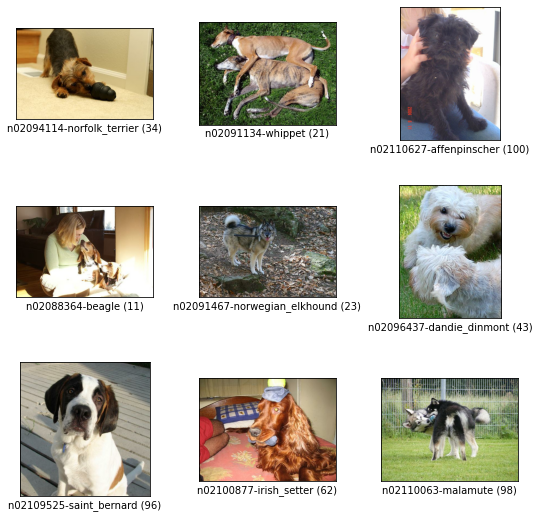

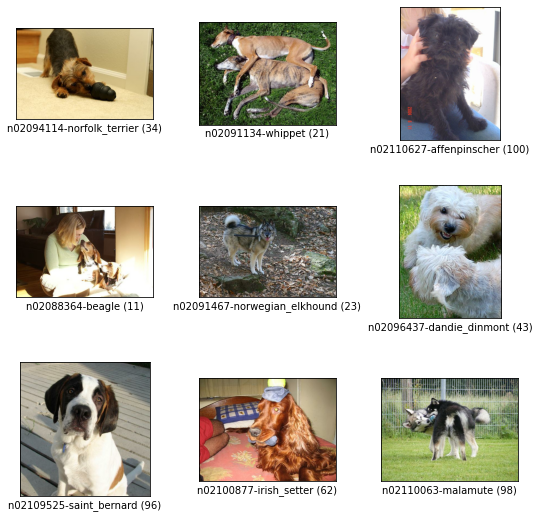

In [7]:
tfds.show_examples(ds_train, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?  
CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.







In [8]:
# def augment2(image,label): # 추가실험 - 나의 변형 시도
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_crop(image) # 잘린 모습의 강아지가 있을 수 있다.
#     image = tf.image.random_brightness(image, max_delta=0.7) # 밝은 환경에서의 강아지가 있을 수 있다.
#     image = tf.clip_by_value(image, 0, 1)
#     return image, label

## random_crop_tensor = tf.image.random_crop(image_tensor, size=(150, 150, 3))  # 무작위 크롭

#### - cutmix 기법

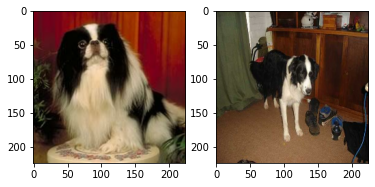

In [13]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [14]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    # 무작위로 중심점을 찾아 설정하는 것
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    # tf.random.uniform([], minval, maxval):
    # 0부터 image_size_x 또는 image_size_y 사이에서 무작위 값 생성.
    # tf.cast(..., tf.int32):
    # 결과를 정수형으로 변환.
    
    
    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    # 1 - tf.random.uniform([], 0, 1)을 통해 무작위로 박스 크기를 결정.
	# tf.math.sqrt는 박스 크기를 줄이는 역할을 합니다.
	# 예: 무작위 값이 0.5라면, \sqrt{0.5} \approx 0.71이므로 크기가 줄어듭니다.
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [15]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역 = image a
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역 덮어쓸 중심영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역 = image a
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    # 세 부분을 하나의 middle 영역으로 결합합니다. 
    # axis=1: 가로 방향(너비)을 기준으로 결합.
    top = image_a[0:y_min, :, :] # 위쪽 영역!, x는 전부 : : image a
    bottom = image_a[y_max:image_size_y, :, :] # 아래쪽 영역!, x는 전부 : : image a
    mixed_img = tf.concat([top, middle, bottom],axis=0) # 모든 영역 세로(높이)로 결합
    
    return mixed_img # 최종 결합된 이미지 반환

In [16]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [17]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b) # return x_min, y_min, x_max, y_max
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


#### - mixup 기법

In [18]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [19]:
# 그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### - 각 기법을 적용할 수 있는 일반화 함수 구현

In [20]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label): # 추가 실험 가능한 부분
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


def onehot(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)

    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds



#     if not is_test:
#         if with_cutmix:
#             ds = ds.map(
#                 cutmix,
#                 num_parallel_calls=2
#             )
#         elif with_mixup: # mixup 함수 추가
#             ds = ds.map(mixup, num_parallel_calls=2)
#         else:
#             ds = ds.map(
#                 onehot,
#                 num_parallel_calls=2
#             )
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

- 모델 학습 중 원핫인코딩 부분에서 계속 오류가 남
- 디버깅 중 영민님 조언으로, 다시 수정
- 디버깅을 혼자서 여러번 반복하다가, if not is_test: 에서 repeat()부분 을 else단락에 넣은 것이,, 오류를 계속 일으키지 않았나 생각

### 2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.



#### - data set 분리

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes


# No Aug
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# Normal Aug 
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# CutMix 적용
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)

# MixUp 적용
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

# ds_test
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

print('=3')

=3


In [22]:
# ResNet50 모델 생성 일반화 함수 (include_top=False 사용)
def create_resnet50_model(input_shape, num_classes):
    # ResNet50의 최상위 레이어를 제외하고, Feature Extractor로 사용
    
    base_model = keras.applications.ResNet50(
        include_top=False,        # 최상단 Fully Connected Layer 제거
        weights='imagenet',       # ImageNet으로 사전 학습된 가중치 사용
        input_shape=input_shape,  
        pooling='avg'             
    )

    # Sequential 모델에 추가 및 사용자 정의 Dense 레이어 추가
    model = keras.models.Sequential([
        base_model,  # ResNet50 Base 모델
        keras.layers.Dense(num_classes, activation='softmax')  # 최종 출력 레이어 (Softmax 사용)
    ])


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.1),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [23]:
# 모델 생성
input_shape = (224, 224, 3)
num_classes=120
resnet50_no_aug = create_resnet50_model(input_shape, num_classes)
resnet50_aug = create_resnet50_model(input_shape, num_classes)
resnet50_cutmix = create_resnet50_model(input_shape, num_classes)
resnet50_mixup = create_resnet50_model(input_shape, num_classes)

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

Q. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?  
우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문




### ➞ 루브릭1. CutMix와 Mixup기법을 Resnet50 분류기에 성공적으로 적용하였는가? 


In [ ]:
# 모델 체크포인트 경로 설정
checkpoint_path = "/aiffel/aiffel//workplace/{label}_best_model.h5"

# 모델 체크포인트 콜백 생성 함수
def get_checkpoint_callback(label):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path.format(label=label),
        monitor='val_loss',    # 검증 정확도를 기준으로 체크포인트 저장
        save_best_only=True,       # 최고 성능 모델만 저장
        save_weights_only=True,    # 가중치만 저장 (모델 구조는 저장 X)
        verbose=1                  # 저장 여부를 출력
    )

# 학습
EPOCHS = 15
BATCH_SIZE = 16
STEPS_PER_EPOCH = ds_info.splits['train'].num_examples // BATCH_SIZE


checkpoint_no_aug = get_checkpoint_callback('No_Aug')
checkpoint_aug = get_checkpoint_callback('Aug')
checkpoint_cutmix = get_checkpoint_callback('CutMix')
checkpoint_mixup = get_checkpoint_callback('MixUp')

# 모델 학습
history_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug,
    validation_data=ds_test,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,  # 에폭당 스텝 수 설정
    callbacks=[checkpoint_no_aug]
)

history_aug = resnet50_aug.fit(
    ds_train_aug,
    validation_data=ds_test,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[checkpoint_aug]
)

history_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    validation_data=ds_test,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[checkpoint_cutmix]
)

history_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    validation_data=ds_test,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[checkpoint_mixup]
)

# 저장 모델 불러오기
# resnet50_no_aug.load_weights("/workspace/No_Aug_best_model.h5")

Epoch 1/15
750/750 [==============================] - 152s 199ms/step - loss: 4.8596 - accuracy: 0.0082 - val_loss: 5.1277 - val_accuracy: 0.0058

Epoch 00001: val_loss improved from inf to 5.12774, saving model to /aiffel/aiffel//workplace/No_Aug_best_model.h5
Epoch 2/15
750/750 [==============================] - 151s 201ms/step - loss: 4.8641 - accuracy: 0.0074 - val_loss: 6.2675 - val_accuracy: 0.0069

Epoch 00002: val_loss did not improve from 5.12774
Epoch 3/15
750/750 [==============================] - 150s 200ms/step - loss: 4.8620 - accuracy: 0.0088 - val_loss: 6.3498 - val_accuracy: 0.0094

Epoch 00003: val_loss did not improve from 5.12774
Epoch 4/15
750/750 [==============================] - 150s 200ms/step - loss: 4.8670 - accuracy: 0.0064 - val_loss: 5.7876 - val_accuracy: 0.0062

Epoch 00004: val_loss did not improve from 5.12774
Epoch 5/15
750/750 [==============================] - 164s 219ms/step - loss: 4.8603 - accuracy: 0.0073 - val_loss: 6.0552 - val_accuracy: 0.009

- 학습 중단됨 -> 모델 체크포인트 활용, 이후 다시 학습

In [29]:
# 모델 체크포인트 경로 설정
checkpoint_path = "/aiffel/aiffel//workplace/{label}_best_model.h5"

# 모델 체크포인트 콜백 생성 함수
def get_checkpoint_callback(label):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path.format(label=label),
        monitor='val_loss',    # 검증 정확도를 기준으로 체크포인트 저장
        save_best_only=True,       # 최고 성능 모델만 저장
        save_weights_only=True,    # 가중치만 저장 (모델 구조는 저장 X)
        verbose=1                  # 저장 여부를 출력
    )

# 학습
EPOCHS = 15
BATCH_SIZE = 16
STEPS_PER_EPOCH = ds_info.splits['train'].num_examples // BATCH_SIZE

checkpoint_no_aug = get_checkpoint_callback('No_Aug')
checkpoint_aug = get_checkpoint_callback('Aug')
checkpoint_cutmix = get_checkpoint_callback('CutMix')
checkpoint_mixup = get_checkpoint_callback('MixUp')

In [30]:
# Aug 모델의 체크포인트 경로
checkpoint_path_aug = "/aiffel/aiffel//workplace/Aug_best_model.h5"

# Aug 모델 체크포인트 불러오기
resnet50_aug.load_weights(checkpoint_path_aug)

# Aug 모델 이어서 학습
history_aug_continue = resnet50_aug.fit(
    ds_train_aug,
    validation_data=ds_test,
    epochs=EPOCHS,                  # 총 학습 에폭
    initial_epoch=6,                # 6번째 에폭 이후부터 시작
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[checkpoint_aug]
)

Epoch 7/15
750/750 [==============================] - 200s 198ms/step - loss: 4.8654 - accuracy: 0.0078 - val_loss: 6.0605 - val_accuracy: 0.0062

Epoch 00007: val_loss improved from inf to 6.06047, saving model to /aiffel/aiffel//workplace/Aug_best_model.h5
Epoch 8/15
750/750 [==============================] - 149s 198ms/step - loss: 4.8973 - accuracy: 0.0084 - val_loss: 5.1721 - val_accuracy: 0.0063

Epoch 00008: val_loss improved from 6.06047 to 5.17215, saving model to /aiffel/aiffel//workplace/Aug_best_model.h5
Epoch 9/15
750/750 [==============================] - 148s 198ms/step - loss: 4.8588 - accuracy: 0.0085 - val_loss: 4.8488 - val_accuracy: 0.0111

Epoch 00009: val_loss improved from 5.17215 to 4.84877, saving model to /aiffel/aiffel//workplace/Aug_best_model.h5
Epoch 10/15
750/750 [==============================] - 148s 198ms/step - loss: 4.8570 - accuracy: 0.0087 - val_loss: 4.8756 - val_accuracy: 0.0062

Epoch 00010: val_loss did not improve from 4.84877
Epoch 11/15
750/

In [32]:
# CutMix 모델의 체크포인트 경로
checkpoint_path_cutmix = "/aiffel/aiffel//workplace/CutMix_best_model.h5"

# # CutMix 모델 체크포인트 불러오기
# resnet50_cutmix.load_weights(checkpoint_path_cutmix)

# CutMix 모델 이어서 학습
history_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    validation_data=ds_test,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[checkpoint_cutmix]
)

Epoch 1/15
750/750 [==============================] - 161s 203ms/step - loss: 5.1909 - accuracy: 0.0078 - val_loss: 5.4436 - val_accuracy: 0.0090

Epoch 00001: val_loss improved from inf to 5.44360, saving model to /aiffel/aiffel//workplace/CutMix_best_model.h5
Epoch 2/15
750/750 [==============================] - 150s 200ms/step - loss: 4.8649 - accuracy: 0.0081 - val_loss: 5.8004 - val_accuracy: 0.0062

Epoch 00002: val_loss did not improve from 5.44360
Epoch 3/15
750/750 [==============================] - 150s 200ms/step - loss: 4.8648 - accuracy: 0.0080 - val_loss: 5.7658 - val_accuracy: 0.0110

Epoch 00003: val_loss did not improve from 5.44360
Epoch 4/15
750/750 [==============================] - 150s 200ms/step - loss: 4.8627 - accuracy: 0.0081 - val_loss: 6.1127 - val_accuracy: 0.0097

Epoch 00004: val_loss did not improve from 5.44360
Epoch 5/15
750/750 [==============================] - 151s 202ms/step - loss: 4.8806 - accuracy: 0.0086 - val_loss: 5.7459 - val_accuracy: 0.010

In [33]:
# MixUp 모델의 체크포인트 경로
checkpoint_path_mixup = "/aiffel/aiffel//workplace/MixUp_best_model.h5"

# # MixUp 모델 체크포인트 불러오기
# resnet50_mixup.load_weights(checkpoint_path_mixup)

# MixUp 모델 이어서 학습
history_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    validation_data=ds_test,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[checkpoint_mixup]
)

Epoch 1/15
750/750 [==============================] - 162s 203ms/step - loss: 5.1682 - accuracy: 0.0066 - val_loss: 5.7412 - val_accuracy: 0.0069

Epoch 00001: val_loss improved from inf to 5.74120, saving model to /aiffel/aiffel//workplace/MixUp_best_model.h5
Epoch 2/15
750/750 [==============================] - 151s 202ms/step - loss: 4.8717 - accuracy: 0.0101 - val_loss: 4.8874 - val_accuracy: 0.0066

Epoch 00002: val_loss improved from 5.74120 to 4.88737, saving model to /aiffel/aiffel//workplace/MixUp_best_model.h5
Epoch 3/15
750/750 [==============================] - 150s 200ms/step - loss: 4.8738 - accuracy: 0.0081 - val_loss: 5.2909 - val_accuracy: 0.0096

Epoch 00003: val_loss did not improve from 4.88737
Epoch 4/15
750/750 [==============================] - 151s 201ms/step - loss: 4.8662 - accuracy: 0.0084 - val_loss: 5.3350 - val_accuracy: 0.0138

Epoch 00004: val_loss did not improve from 4.88737
Epoch 5/15
750/750 [==============================] - 151s 202ms/step - loss: 

In [ ]:
# # 시간되면 다시 학습해보기. 모델체크포인트는 있지만, (history 통해 그래프 그려야하기 때문)
# checkpoint_path_noaug = "/aiffel/aiffel//workplace/No_Aug_best_model2.h5"

# history_no_aug = resnet50_no_aug.fit(
#     ds_train_no_aug,
#     validation_data=ds_test,
#     epochs=EPOCHS,
#     steps_per_epoch=STEPS_PER_EPOCH,  # 에폭당 스텝 수 설정
#     callbacks=[checkpoint_no_aug]
# )

### 결과 정리 이후, 에폭 추가로 더 돌려보기

### 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.



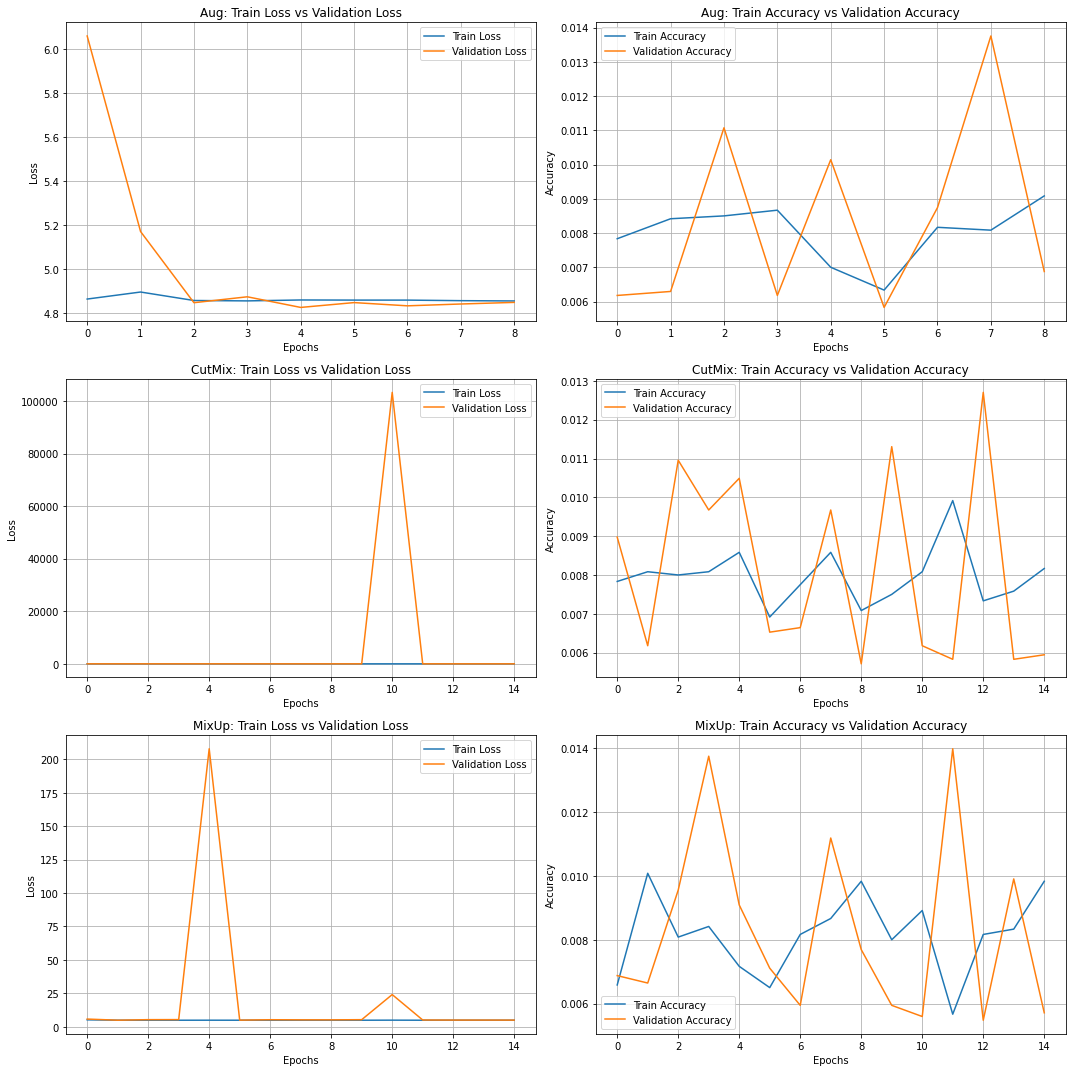

In [35]:
# 모델별 히스토리 (No Aug 제외) - 훈련도중 끊김
histories = [history_aug_continue, history_cutmix, history_mixup]
labels = ['Aug', 'CutMix', 'MixUp']

# 각 모델별 Train vs Validation Loss/Accuracy 그래프
plt.figure(figsize=(15, 15))
for i, (history, label) in enumerate(zip(histories, labels)):
    # Train Loss vs Validation Loss
    plt.subplot(3, 2, i * 2 + 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{label}: Train Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Train Accuracy vs Validation Accuracy
    plt.subplot(3, 2, i * 2 + 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{label}: Train Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


- Train loss가 감소하지 않는 것으로 보아 학습에 무제가 있는것으로 보입니다.
- 모델을 생성하는 함수에서 문제가 있는것으로 보여, 추가적인 디버깅이 필요할 것으로 보입니다.
- accuracy 또한 증가하지 않고, 진동함에 따라 모델의 학습에 문제가 있음이 확인됩니다.
- 시간상 학습이 끝난 이후 저녁에 디버깅을 이어서 하도록 하겠습니다!

In [ ]:
# # No Aug 포함
# # 모델별 히스토리
# histories = [history_no_aug, history_aug, history_cutmix, history_mixup]
# labels = ['No Aug', 'Aug', 'CutMix', 'MixUp']

# # 각 모델별 Train vs Validation Loss/Accuracy 그래프
# plt.figure(figsize=(20, 20))
# for i, (history, label) in enumerate(zip(histories, labels)):
#     # Train Loss vs Validation Loss
#     plt.subplot(4, 2, i * 2 + 1)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title(f'{label}: Train Loss vs Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()

#     # Train Accuracy vs Validation Accuracy
#     plt.subplot(4, 2, i * 2 + 2)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title(f'{label}: Train Accuracy vs Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid()

# plt.tight_layout()
# plt.show()


### 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.



### ➞ 루브릭2. 다양한 실험을 통해 테스크에 최적인 Aug기법을 찾아내었는가? (성능비교 분석 및 문제점 서술)
### ➞ 루브릭3. 여러가지 Aug기법을 적용한 결과를 체계적으로 비교분석 하였는가?

In [ ]:
# val_loss 및, val_accuracy 비교
import pandas as pd

# 모델 로드
def load_model_and_evaluate(model, checkpoint_path, validation_data):
    model.load_weights(checkpoint_path)
    results = model.evaluate(validation_data, verbose=0)
    return results  # [loss, accuracy]

checkpoint_paths = {
    'No Aug': '/aiffel/aiffel//workplace/No_Aug_best_model.h5',
    'Aug': '/aiffel/aiffel//workplace/Aug_best_model.h5',
    'CutMix': '/aiffel/aiffel//workplace/CutMix_best_model.h5',
    'MixUp': '/aiffel/aiffel//workplace/MixUp_best_model.h5'
}

# 각 모델의 평가 결과
evaluation_results = {}

for label, checkpoint_path in checkpoint_paths.items():
    model = create_resnet50_model(input_shape, num_classes)  # 모델 초기화
    loss, accuracy = load_model_and_evaluate(model, checkpoint_path, ds_test)  # 모델 체크포인트 로드 후 평가
    evaluation_results[label] = {
        'val_loss': loss,
        'val_accuracy': accuracy
    }

df_metrics = pd.DataFrame.from_dict(evaluation_results, orient='index')
print(df_metrics)

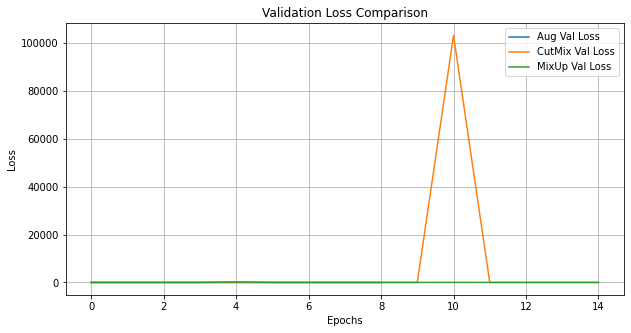

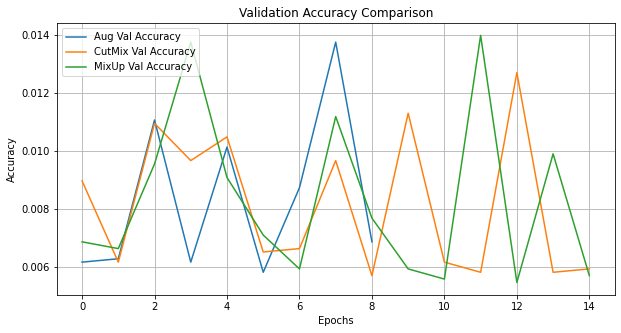

In [36]:
# 3개 모델 시각화 비교

# Validation Loss 비교
plt.figure(figsize=(10, 5))
for history, label in zip(histories, labels):
    plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Validation Accuracy 비교
plt.figure(figsize=(10, 5))
for history, label in zip(histories, labels):
    plt.plot(history.history['val_accuracy'], label=f'{label} Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# # 4개 모델의 Validation Loss 비교

# plt.figure(figsize=(12, 6))
# for history, label in zip(histories, labels):
#     plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
# plt.title('Validation Loss Comparison')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.show()


In [ ]:
# # 4개 모델의 Validation Accuracy 비교

# plt.figure(figsize=(12, 6))
# for history, label in zip(histories, labels):
#     plt.plot(history.history['val_accuracy'], label=f'{label} Val Accuracy')
# plt.title('Validation Accuracy Comparison')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.show()

1.No Aug
- 모델 체크포인트를 저장하였으나, 히스토리를 저장하지 못해 시각화를 하지 못했습니다.
- 학습 시간상, 재학습을 하지 못한점이 아쉽지만 evaluate를 통해 best 모델 기준, 각 성능을 비교해보았습니다.
- 시각화를 통해 본다면, 데이터의 다양성이 부족하여 오버피팅 현상이 있을 것으로 예측됩니다.

2.Aug:
- 기본적인 random flip, brightenss의 증강기법을 적용하였습니다.
- 데이터의 다양성이 일부 증가하여, 과적합을 줄이는데 도움이 될거라 예측됩니다.
- (모델 재학습 이후 시각화 분석을 이어서 진행하도록 하겠습니다.)

3.cutmix:
- 특정영역을 잘라낸뒤 다른 이미지에 삽입하느 방식으로 두 이미지를 섞어 새로운 샘플을 만드는 기법입니다.
- 잘라낸 영역의 비율에 따라 라벨을 조합합니다.
- 배경과 객체 간 관계를 학습합니다.
- (모델 재학습 이후 시각화 분석을 이어서 진행하도록 하겠습니다.)

4.mixup:
- 두 샘플의 픽셀과 라벨을 선형적으로 결합하여, 새로운 샘플을 생성하는 기법입니다.
- 선형 조합 비율에 따라 라벨을 조합합니다.
- 데이터 경계를 부드럽게 하여 일반화 성능을 향상시킵니다.
- (모델 재학습 이후 시각화 분석을 이어서 진행하도록 하겠습니다.)

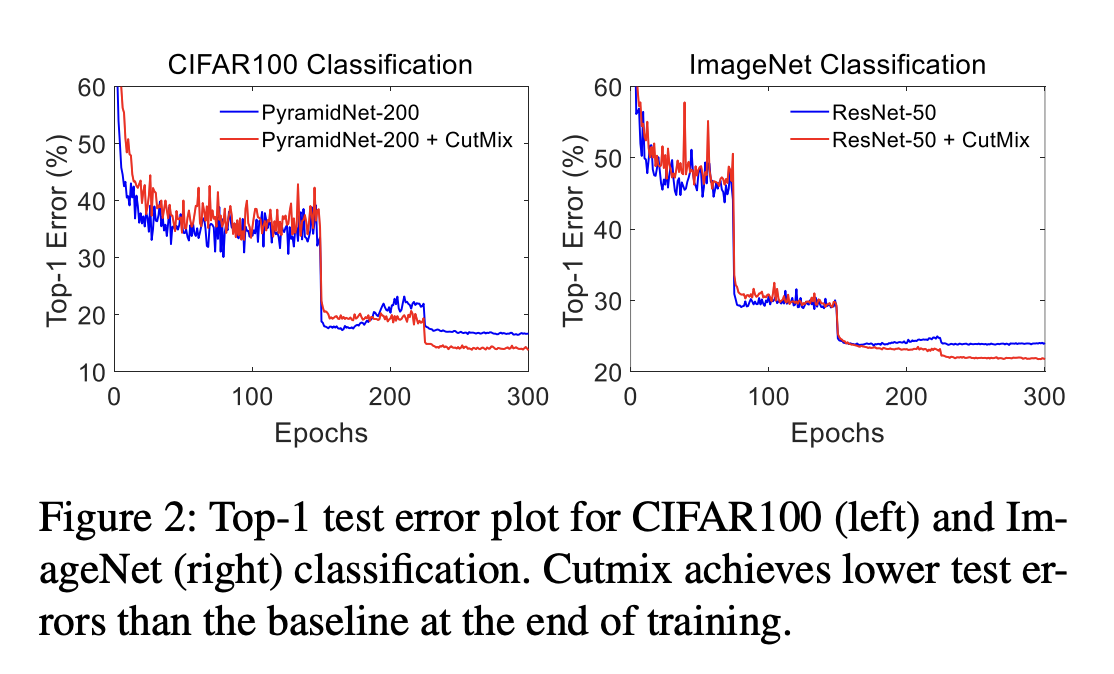
- 참고 논문

### 추가실험 
- 기본 Augmentation 함수를 추가 변형시 더 효과가 있을까?
- 에폭을 300까지 해볼수 없는 환경 고려
- 낮은 에폭을 기준으로 보았을 때, 해볼 수 있는 시도

In [ ]:
def augment2(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image) # 잘린 모습의 강아지가 있을 수 있다.
    image = tf.image.random_brightness(image, max_delta=0.6) # 밝은 환경에서의 강아지가 있을 수 있다.
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, num_classes=120):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if not is_test and with_aug 
        ds = ds.map(augment2, num_parallel_calls=tf.data.experimental.AUTOTUNE) #변형

    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    return ds

ds_train_aug2 = apply_normalize_on_dataset(ds_train, with_aug=True)


- 모델 재학습을 완료한 이후, 추가실험을 진행하겠습니다.

### 최종회고 
- 비교실험을 수행할 시, 항상 모델체크포인트 뿐만 아니라 history를 저장하는 습관을 들이자. 시각화 및 성능 비교 분석을 위해.
- 원핫인코딩 부분의 디버깅에 시간을 많이 쏟게 되었다. 학습에 시간이 오래걸려 추가실험을 많이 해보지 못한점이 아쉽다.
- val loss와 val accuracy, 그리고 일반화 성능을 바라보는 관점에 대해 퍼실님과 토론하며 새롭게 알게된 지식이 많다.
- val accuracy가 높다고 무조건 일반화 성능이 좋다? 그점은 아니다. 학습한 패턴과 전혀 다른(val_data도 일부 학습 패턴과 유사한 점이 있음) test data에 대한 성능을 바라보는 관점도 갖자.
- 모델 학습에 문제가 있음을 3시간을 돌리고 난 뒤에 알게 됐다... 한모델을 돌린 뒤 -> 시각화하고 -> 문제점 개선 이후 전 모델을 돌리는 방향으로 설계했어야 함을 깨달았다.
- 러닝레이트를 좀더 큰폭으로 잡고, 5~8에폭 정도를 실험해 본 뒤 -> 학습이 원활하게 진행될 때 전 모델을 학습시키는 방향으로 앞으로 설계해야 겠다.


### 루브릭
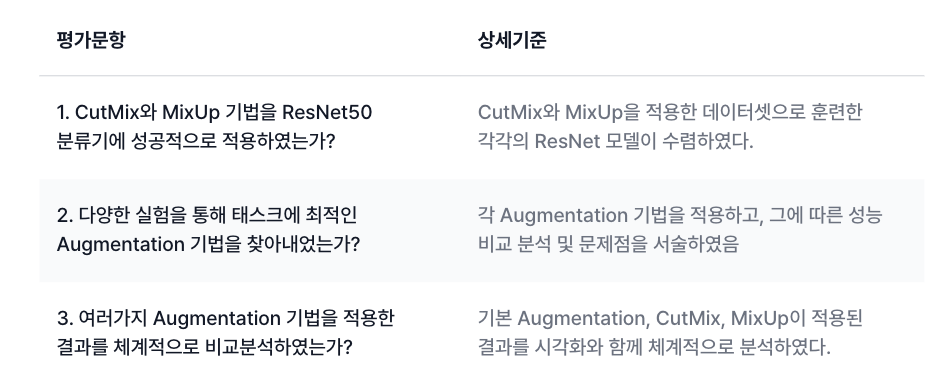


## Augmentation 노드 학습

In [ ]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os

sample_img_path = os.getenv('HOME')+'/aiffel/data_augmentation/images/mycat.jpg'
sample_img_path

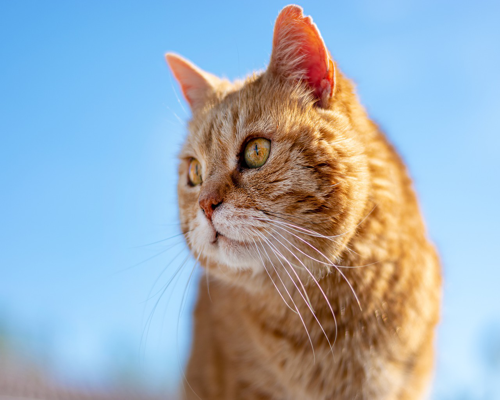

In [2]:
image = Image.open(sample_img_path).resize((500, 400)) # 이미지에 따라 숫자를 바꾸어 보세요.
image_tensor = tf.keras.preprocessing.image.img_to_array(image)

image

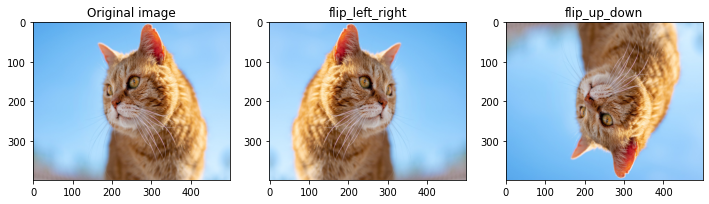

In [3]:
# Flip 적용
# Flip을 적용해줍시다. Flip은 flip_left_right와 flip_up_down 두 가지로 좌우와 상하 반전으로 구분됩니다.

flip_lr_tensor = tf.image.flip_left_right(image_tensor)
flip_ud_tensor = tf.image.flip_up_down(image_tensor)
flip_lr_image = tf.keras.preprocessing.image.array_to_img(flip_lr_tensor)
flip_ud_image = tf.keras.preprocessing.image.array_to_img(flip_ud_tensor)

plt.figure(figsize=(12, 12))

plt.subplot(1,3,1)
plt.title('Original image')
plt.imshow(image)

plt.subplot(1,3,2)
plt.title('flip_left_right')
plt.imshow(flip_lr_image)

plt.subplot(1,3,3)
plt.title('flip_up_down')
plt.imshow(flip_ud_image)

plt.show()

위의 함수들은 일괄적으로 상하 또는 좌우 반전을 적용합니다. 우리는 이를 확률에 따라서 적용되도록 해야 합니다. 그래야 반전이 되지 않은 원본 데이터도 활용이 될 수 있기 때문이죠. 이를 위해서 활용할 수 있는 것이 random_flip_left_right와 random_flip_up_down입니다. 필요에 따라서는 직접 이 둘을 합쳐서 random_flip으로 상하좌우 반전을 적용하는 함수를 직접 만들어 볼 수 있겠네요. 아래 코드를 반복해서 돌려보면서 random augmentation이 어떻게 작동하는지 직접 확인해 봅시다!






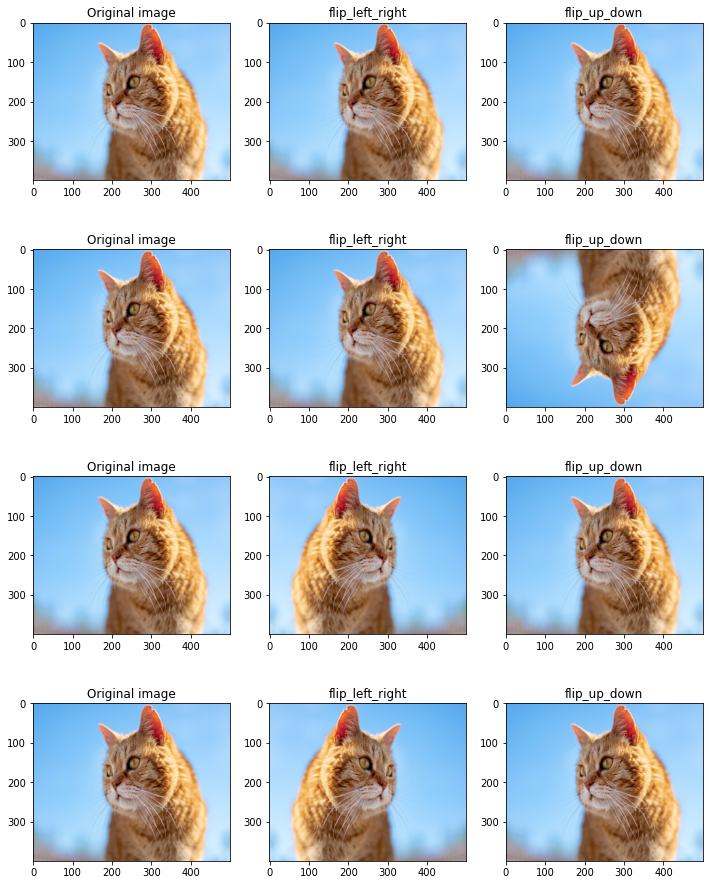

In [4]:
plt.figure(figsize=(12, 16))

row = 4
for i in range(row):
    flip_lr_tensor = tf.image.random_flip_left_right(image_tensor)
    flip_ud_tensor = tf.image.random_flip_up_down(image_tensor)
    flip_lr_image = tf.keras.preprocessing.image.array_to_img(flip_lr_tensor)
    flip_ud_image = tf.keras.preprocessing.image.array_to_img(flip_ud_tensor)
    
    plt.subplot(4,3,i*3+1)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(4,3,i*3+2)
    plt.title('flip_left_right')
    plt.imshow(flip_lr_image)

    plt.subplot(4,3,i*3+3)
    plt.title('flip_up_down')
    plt.imshow(flip_ud_image)

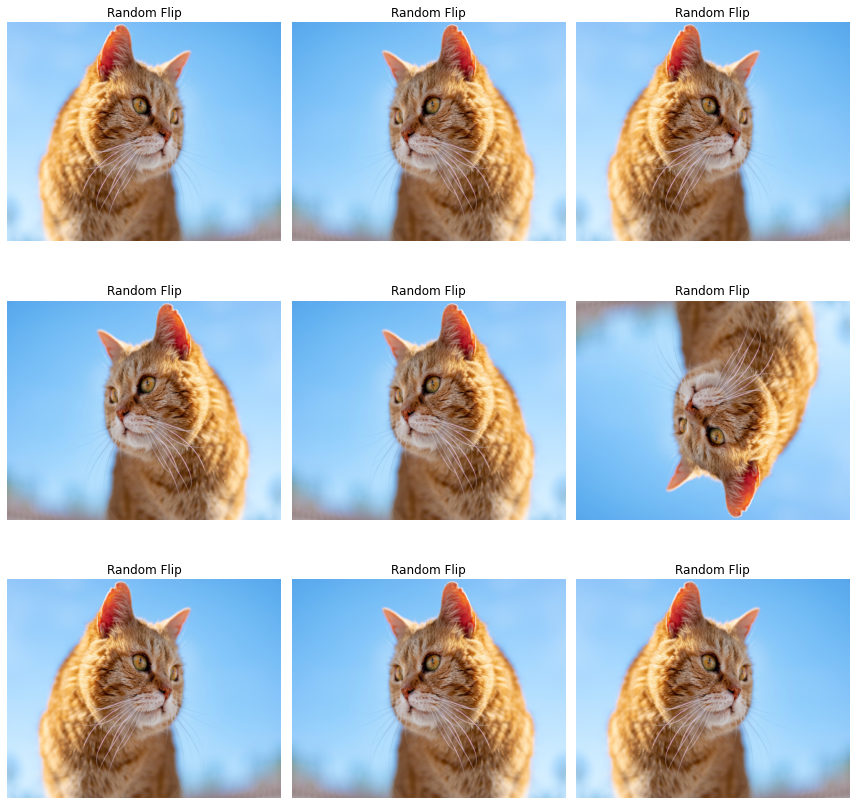

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

# random_flip 함수 정의
def random_flip(image_tensor):
    """
    이미지 텐서를 받아 좌우 및 상하로 무작위로 뒤집은 이미지를 반환합니다.
    """
    # 좌우 뒤집기
    flip_lr_tensor = tf.image.random_flip_left_right(image_tensor)
    flip_lr_image = tf.keras.preprocessing.image.array_to_img(flip_lr_tensor)

    # 상하 뒤집기
    flip_ud_tensor = tf.image.random_flip_up_down(image_tensor)
    flip_ud_image = tf.keras.preprocessing.image.array_to_img(flip_ud_tensor)

    return flip_lr_image, flip_ud_image

# 시각화
plt.figure(figsize=(12, 12))

# 9개의 이미지를 랜덤으로 뒤집어 시각화
for i in range(9):
    # 원본 이미지 및 뒤집힌 이미지 생성
    flip_lr_image, flip_ud_image = random_flip(image_tensor)

    # 서브플롯에 원본 및 뒤집힌 이미지 시각화
    plt.subplot(3, 3, i + 1)
    plt.title('Random Flip')
    plt.imshow(flip_lr_image if i % 2 == 0 else flip_ud_image)
    plt.axis('off')

plt.tight_layout()
plt.show()

Center crop은 이전에 설명드렸던 것과 같이 중앙을 기준으로 자른 이미지를 사용하는 augmentation 기법입니다.

단순하게 중심점을 기준으로 사진을 확대하는 것으로 생각하기 쉽지만, 적용할 때 주의해 사용해야 합니다. central_fraction은 얼마나 확대를 할지를 조절하는 매개변수입니다. 1.0인 경우는 원본 이미지와 같습니다. 그러나 예를 들어 고양이 이미지를 확대하면 0.5까지는 보일 수 있지만 0.25 수준으로 내려가면 털만 보이고 고양이의 형상을 찾기 어려울 수 있습니다. 따라서 central_fraction의 범위를 문제가 생기지 않는 범위에서 랜덤하게 조절되도록 해야 합니다.






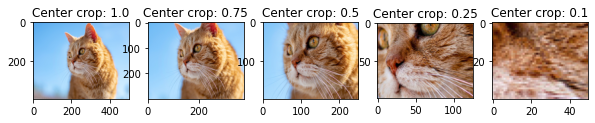

In [8]:
plt.figure(figsize=(12, 15))

central_fractions = [1.0, 0.75, 0.5, 0.25, 0.1]
col = len(central_fractions)
for i, frac in enumerate(central_fractions):
    cropped_tensor = tf.image.central_crop(image_tensor, frac)
    cropped_img = tf.keras.preprocessing.image.array_to_img(cropped_tensor)
    
    plt.subplot(1,col+1,i+1)
    plt.title(f'Center crop: {frac}')
    plt.imshow(cropped_img)

In [15]:
def random_central_crop(image_tensor, range=(0, 1)):
    # range 범위에서 무작위로 잘라낼 비율을 선택합니다
    central_fraction = tf.random.uniform([1], minval=range[0], maxval=range[1], dtype=tf.float32)
    cropped_tensor = tf.image.central_crop(image_tensor, central_fraction)
    return cropped_tensor
print('=3')

=3


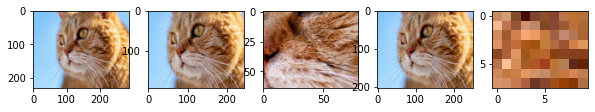

In [20]:
plt.figure(figsize=(12, 15))

col = 5
for i in range(col):
    cropped_tensor = random_central_crop(image_tensor)
    cropped_img = tf.keras.preprocessing.image.array_to_img(cropped_tensor)
    
    plt.subplot(1,col+1,i+1)
    plt.imshow(cropped_img)

In [24]:
def random_central_crop(image_tensor, range=(0.25, 1)): # range 수정
    # range 범위에서 무작위로 잘라낼 비율을 선택합니다
    central_fraction = tf.random.uniform([1], minval=range[0], maxval=range[1], dtype=tf.float32)
    cropped_tensor = tf.image.central_crop(image_tensor, central_fraction)
    return cropped_tensor
print('=3')

=3


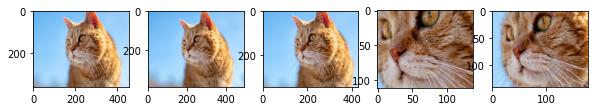

In [26]:
plt.figure(figsize=(12, 15))

col = 5
for i in range(col):
    cropped_tensor = random_central_crop(image_tensor)
    cropped_img = tf.keras.preprocessing.image.array_to_img(cropped_tensor)
    
    plt.subplot(1,col+1,i+1)
    plt.imshow(cropped_img)

- 추가 공부
image_tensor = tf.keras.preprocessing.image.img_to_array(image)

    주요 기능
	1.	PIL 이미지 또는 다른 포맷 → NumPy 배열 변환:  
	•	PIL 이미지는 Image.open()으로 로드한 이미지 객체로, 딥러닝 모델 학습에 직접 사용할 수 없습니다.  
	•	이 함수는 이러한 이미지를 TensorFlow에서 사용하는 형태인 NumPy 배열로 변환합니다.
	2.	배열 차원 추가:  
	•	변환된 NumPy 배열은 기본적으로 (height, width, channels) 형식을 갖습니다.  
	•	이는 TensorFlow에서 처리할 수 있는 형식으로 맞춥니다.  
	3.	데이터 타입 변환:   
	•	이미지 데이터는 일반적으로 uint8(0~255 값의 8비트 정수)로 표현되며, 변환 후에도 동일하게 유지됩니다.  
	•	후속 작업에서 정규화(예: /255.0으로 나누기)를 통해 float32 타입으로 변환하여 학습에 사용됩니다.  
    
    

Q. 텐서플로우의 tf.random 모듈에는 무작위성을 지닌 데이터를 얻을 수 있는 함수가 여러 가지 있습니다. 그 중 tf.random.uniform() 과 tf.random.normal() 의 차이는 뭘까요? 공식 문서를 보고 답해 보세요.

1. tf.random.uniform()
	•	정의: 균등 분포 (Uniform Distribution)에서 난수를 생성합니다.
	•	분포: 주어진 최소값과 최대값 사이에서 모든 값이 동일한 확률로 선택됩니다.  
tf.random.uniform(shape=(3, 3), minval=0, maxval=10, dtype=tf.float32)
    
2. tf.random.normal()
	•	정의: 정규 분포 (Normal Distribution)에서 난수를 생성합니다.
	•	분포: 주어진 평균값과 표준편차를 기준으로 난수가 생성됩니다.  
tf.random.normal(shape=(3, 3), mean=0, stddev=1, dtype=tf.float32)

이제 직접 augmentation을 활용해 보는 시간을 갖겠습니다. 직접 사용할 함수는 tf.image.random_crop()와 tf.image.random_brightness()입니다.



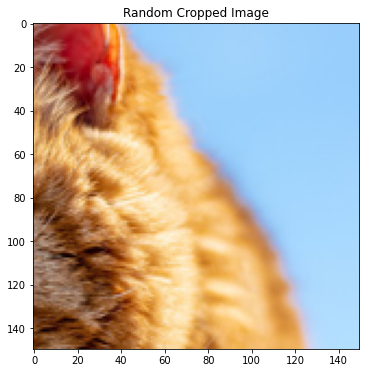

In [27]:
# 랜덤 크롭 적용
random_crop_tensor = tf.image.random_crop(image_tensor, size=(150, 150, 3))  # 무작위 크롭
random_crop_image = tf.keras.preprocessing.image.array_to_img(random_crop_tensor)  # 텐서를 이미지로 변환

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(random_crop_image)
plt.title('Random Cropped Image')
plt.show()

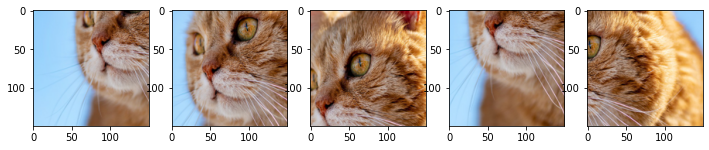

In [30]:
# display 5 random cropped images
plt.figure(figsize=(12, 15))

for i in range(5):
  random_crop_tensor = tf.image.random_crop(image_tensor, size=(150,150,3)) # 여기에 코드를 입력해 주세요. #
  random_crop_image = tf.keras.preprocessing.image.array_to_img(random_crop_tensor)# 여기에 코드를 입력해 주세요. #
  plt.subplot(1, 5, i + 1) # 현재 플롯할 서브플롯의 위치 지정
  # 여기에 코드를 입력해 주세요. hint : plt.subplot()
  plt.imshow(random_crop_image)


두 번째로 적용할 함수는 tf.image.random_brightness()입니다. 공식 문서를 확인하면서 이미지에 적용해 봅시다.



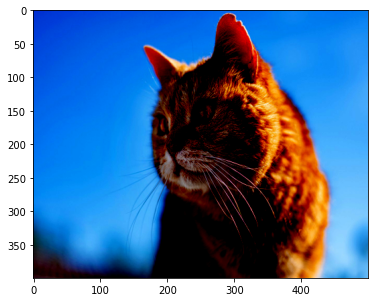

In [32]:
# apply random_brightness on cat image 
plt.figure(figsize=(6, 8))

random_bright_tensor = tf.image.random_brightness(image_tensor, max_delta=150)
# 여기에 코드를 입력해 주세요. # hint : 밝기 변화가 느껴지지 않나요? delta값을 변경해보세요. 예) max_delta=128
cliped_random_bright_tensor = tf.clip_by_value(random_bright_tensor, 0,255 ) 
# <--여기에 코드를 입력해 주세요. hint :random_brightness()를 통과한 텐서의 값들중 0~255를 벗어나는 값이 있진 않을까요? 나머지 두개 인자를 어떻게 주어야할까요?
# 밝기 값이 0~255 범위를 초과하지 않도록 클리핑

random_bright_image = tf.keras.preprocessing.image.array_to_img(cliped_random_bright_tensor)

plt.imshow(random_bright_image)
plt.show()

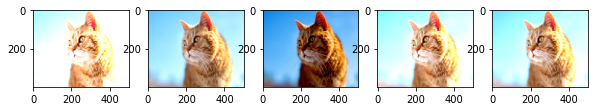

In [34]:
# display 5 random brightness images

plt.figure(figsize=(12, 15))

col = 5
for i in range(5):
    random_bright_tensor = tf.image.random_brightness(image_tensor, max_delta=125)
    cliped_random_bright_tensor = tf.clip_by_value(random_bright_tensor, 0,255)
    random_bright_image = tf.keras.preprocessing.image.array_to_img(cliped_random_bright_tensor)
    
    # 여기에 코드를 입력해 주세요.
    # 여기에 코드를 입력해 주세요.
    # 여기에 코드를 입력해 주세요.

    plt.subplot(1,col+1,i+1)
    plt.imshow(random_bright_image)

지금까지 텐서플로우에서 기본적으로 제공되는 augmentation 함수들을 확인해 봤습니다. 이러한 augmentation만을 모아서 제공하는 전문 라이브러리들이 있는데요. 이번에는 그중 albumentations 라이브러리를 활용하겠습니다. albumentations은 이미지 증강을 위한 Python 라이브러리입니다. 이미지 증강은 딥 러닝 및 컴퓨터 비전 작업에서 훈련된 모델의 품질을 높이는 데 사용됩니다.  
augmentation에서는 배열을 이미지의 기본 형태로 사용합니다. 따라서 PIL Image 데이터형을 넘파이(numpy) 배열로 변환하여 사용하도록 합니다.







In [35]:
import numpy as np
image = Image.open(sample_img_path).resize((400, 300)) # W400,H300 # 이미지에 따라 숫자를 바꾸어 보세요.
image_arr = np.array(image)
image_arr.shape

(300, 400, 3)

H, W, c

In [43]:
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

print("슝")

슝


transforms.Affine()
이제 위에서 확인해보지 않았던 augmentation 중 하나를 해봅시다. transforms.Affine()의 Affine()은 아핀 변환(Affine transform)을 이미지에 적용합니다. 2D 변환의 일종인 아핀 변환은 이미지의 스케일(scale)을 조절하거나 평행이동, 또는 회전 등의 변환을 줄 수 있습니다. 자세한 내용은 아래 참고 자료를 확인해 보세요.

transforms.Affine()
아래 코드를 실행하시면 -45도와 45도 사이에 랜덤하게 각도를 변환하는 augmention을 10장 볼 수 있습니다.

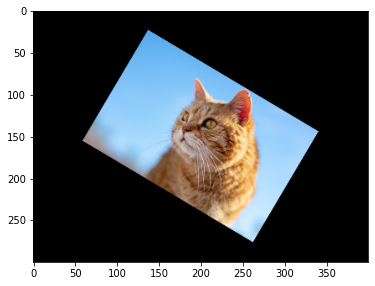

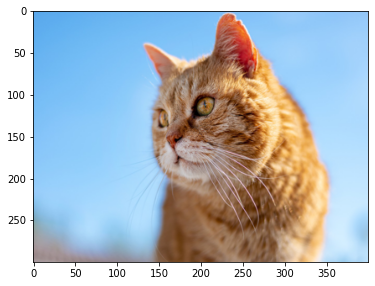

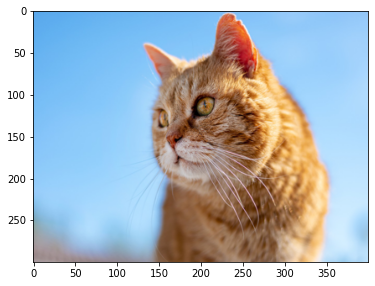

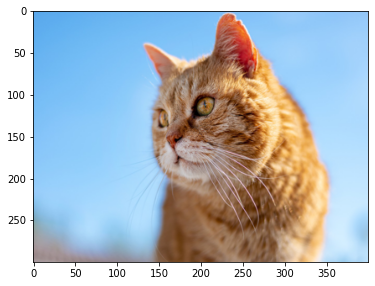

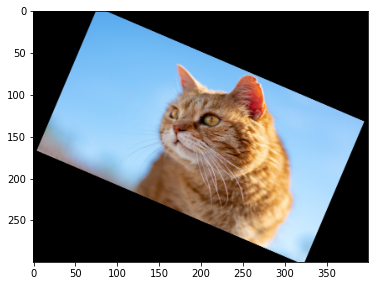

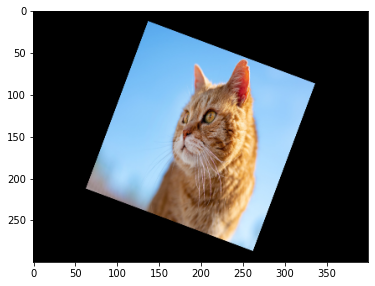

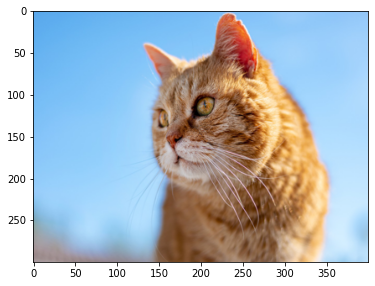

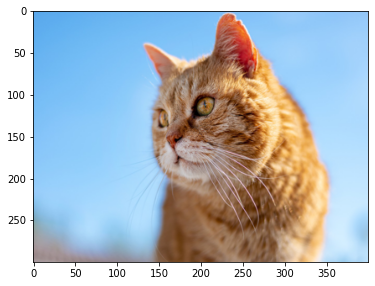

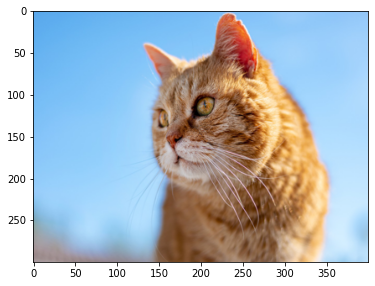

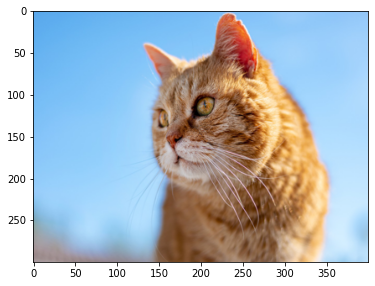

In [38]:
import albumentations as A

for i in range(10):
    transform = A.Compose([ # 여러 변환을 결합하여 하나의 파이프라인 생성
        A.Affine(rotate=(-45, 45),scale=(0.5,0.9),p=0.5)  # 변환이 적용될 확률 50%
    ])
    transformed = transform(image=image_arr) # 배열 형태의 입력 이미지
    plt.figure(figsize=(6,6)) # 플롯 크기 설정
    plt.imshow((transformed['image']))
    # 변환된 결과는 딕셔너리 형태로 반환됩니다.
    # transformed['image']: 변환된 이미지 배열.

    plt.show()

transforms.RandomCrop()
이번에는 RandomCrop()을 사용해서 256x256 정도의 부분을 랜덤하게 짤 10개 정도 생성해 보겠습니다. 자세한 내용은 아래 참고 자료를 확인해 보세요.

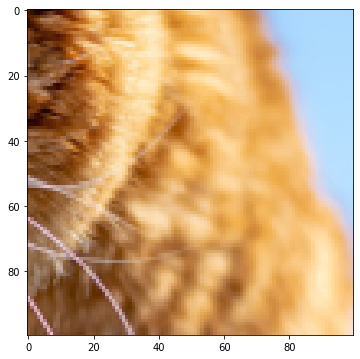

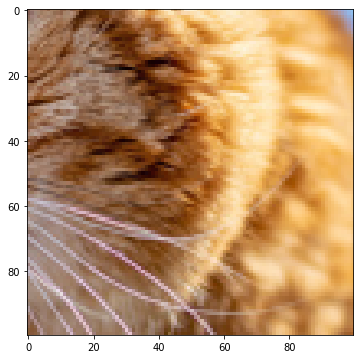

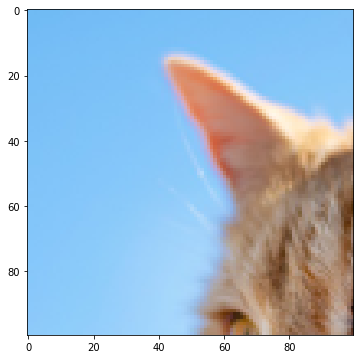

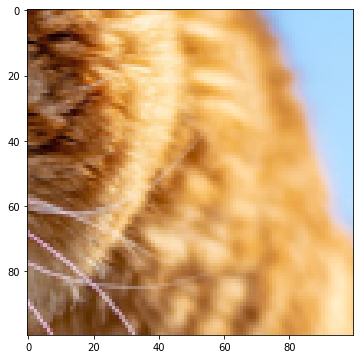

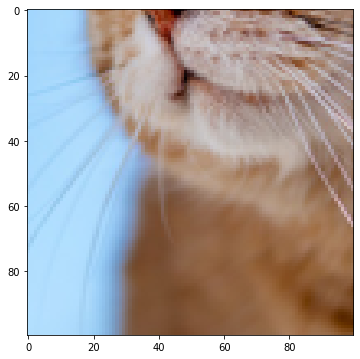

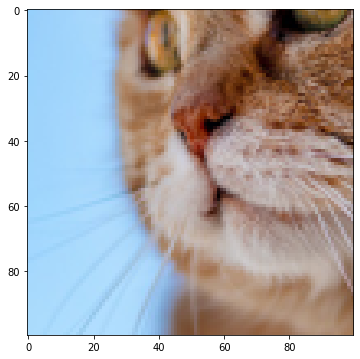

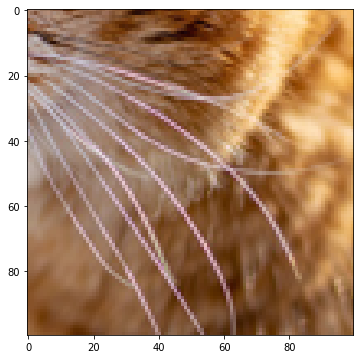

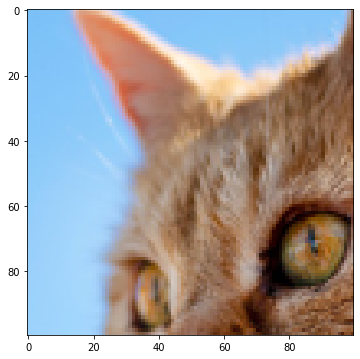

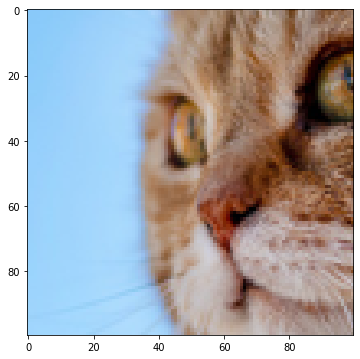

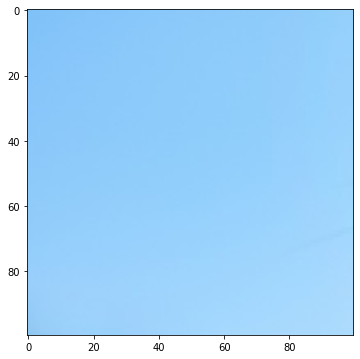

In [44]:
for i in range(10):
    transform = A.Compose(
        [A.RandomCrop(width=100, height=100)]
    )
    transformed = transform(image=image_arr)
    visualize(transformed['image'])

MedianBlur()
MedianBlur()를 활용하여 블러처리를 쉽게 할수 있습니다.






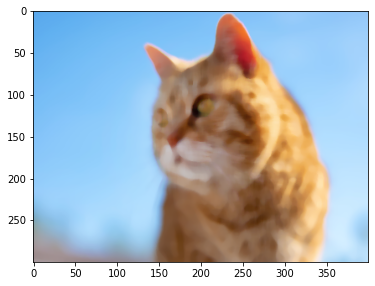

In [51]:
transform = A.Compose(
    [A.MedianBlur(blur_limit=21, always_apply=False, p=0.5)]
)
# blur_limit 커널 크기는 항상 홀수여야 함
# blur_limit=(3, 9) 이 범위안에서 무작위 설정 가능
transformed = transform(image=image_arr)
visualize(transformed['image'])

ToGray(),MultiplicativeNoise()
이렇게 하나씩 기법을 적용하다 보면 "augmentation 기법들을 한 번에 조합하여 사용할 수는 없을까?" 라는 생각이 듭니다. 아래 코드 처럼 여러 가지의 augmentation 기법을 순차적으로 적용할 수 있습니다. 아래 코드에서는 위에서 사용한 ToGray()와 MultiplicativeNoise() 이 적용된 결과를 볼 수 있습니다.






In [ ]:
transform = A.Compose(
    [A.ToGray(p=1),
    A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=1)]
)
transformed = transform(image=image_arr)
visualize(transformed['image'])

ToGray(),MultiplicativeNoise()
이렇게 하나씩 기법을 적용하다 보면 "augmentation 기법들을 한 번에 조합하여 사용할 수는 없을까?" 라는 생각이 듭니다. 아래 코드 처럼 여러 가지의 augmentation 기법을 순차적으로 적용할 수 있습니다. 아래 코드에서는 위에서 사용한 ToGray()와 MultiplicativeNoise() 이 적용된 결과를 볼 수 있습니다.






In [13]:
transform = A.Compose(
    [A.ToGray(p=1),
    A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=1)]
)
transformed = transform(image=image_arr)
visualize(transformed['image'])

NameError: name 'A' is not defined

지금 까지 사용해본 내용을 토대로 그래이 색상의 노이즈가 있는 RandomCrop()을 사용하여 고양이 이미지 100장을 시각화해 보세요!





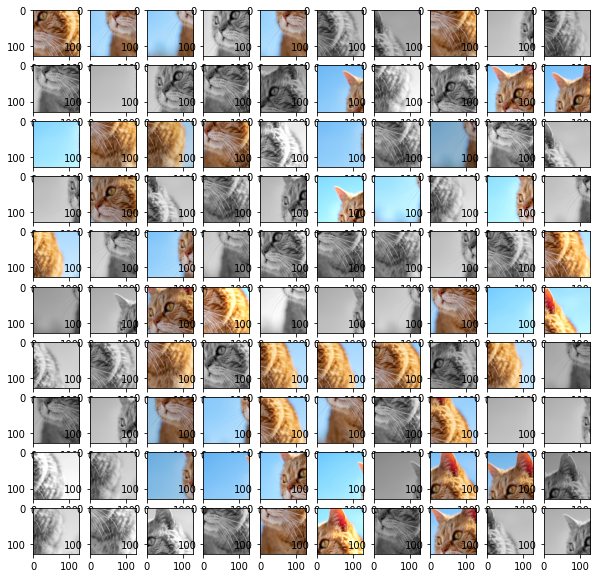

In [56]:
# Use various techniques and functions in albumentations library. show 100 images.
# 여기에 코드를 입력해 주세요.
def transform_data(img_arr):
    transform = A.Compose(
        [
         A.ToGray(p=0.6), # 여기에 코드를 입력해 주세요. hint : A.ToGray()
         A.MultiplicativeNoise(multiplier=(0.8, 1.2), p=0.5), # 여기에 코드를 입력해 주세요. hint : A.MultiplicativeNoise()
         A.RandomCrop(height=128, width=128, p=1.0) # 여기에 코드를 입력해 주세요. hint : A.RandomCrop()
        ]
    )
    t_image = transform(image=img_arr)
    # Compose로 정의된 변환을 입력 이미지 img_arr에 적용
    # 변환된 이미지를 포함하는 딕셔너리 반환. 예: {'image': transformed_image}.
    t_image = t_image['image']
    # 변환된 이미지 데이터만 추출
    return t_image

plt.figure(figsize=(10,10))
for i in range(100):
    image = transform_data(image_arr)
    plt.subplot(10,10,i+1)
    plt.imshow(image)

# 노드5

이번 노드에서는 augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수 있는지 공부하겠습니다. 지금까지 모델을 훈련시키기 전, 데이터를 전처리해 입력값으로 사용해 오셨을 것입니다. Augmentation도 이처럼 입력 이미지의 데이터를 변경해 주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일합니다. 먼저 필요한 라이브러리들을 불러와 줍니다.






In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

그리고 사용할 데이터셋을 불러옵니다. 이번 시간에는 stanford_dogs 데이터셋을 사용해보도록 합시다. stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

데이터를 처음 사용한다면 다운로드해야 하기 때문에 시간이 오래(10분 이상) 걸릴 수 있습니다. 당황하지 마시고 잠시 휴식 시간을 가져 보세요. 데이터셋은 다른 프로젝트에서도 사용할 수 있으니 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장합시다.

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


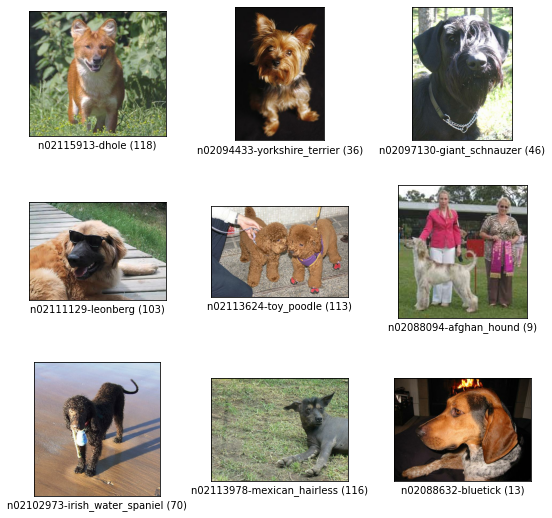

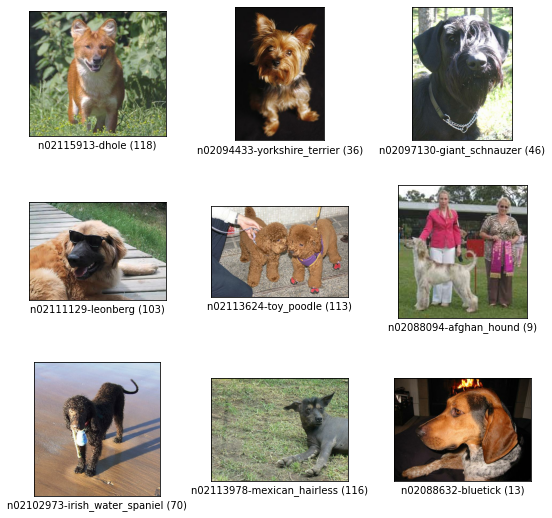

In [6]:
tfds.show_examples(ds_train, ds_info)

텐서플로우 Random Augmentation API 사용하기
많은 augmentation 기법들이 있지만 그중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

random_brightness()
random_contrast()
random_crop()
random_flip_left_right()
random_flip_up_down()
random_hue()
random_jpeg_quality()
random_saturation()
그럼 Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


이미지를 변환하는 전처리 함수는 대략 다음과 같은 형태를 가지게 됩니다.

    def 전처리_함수(image, label):   # 변환할 이미지와 라벨
        # 이미지 변환 로직 적용
        new_image = 이미지_변환(image)
        return new_image, label
    
이렇게 되면 이미지 변환의 결과로 리턴 받은 이미지를 그다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리합니다. 위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있습니다. 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.

맨 위에서 언급한 random augmentation들 중에서 random_flip_left_right()과 random_brightness()를 활용해 보겠습니다. "flip"의 경우 좌우 대칭을 해줍니다. 예컨대 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않습니다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 합니다. 여기서 상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않습니다. 또 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠습니다.

In [8]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 apply_normalize_on_dataset()로 정의하겠습니다.
여기서는 apply_normalize_on_dataset()를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다. 이때 주의해야 할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점입니다.

여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있습니다. 이는 캐글 등의 경쟁 머신러닝에 많이 사용되지만, 지금은 개념만 알아두어도 됩니다. 아래 링크에서 test-time augmentation에 관한 설명을 참고하세요.

테스트 타임 증강 (Test Time Augmentation, TTA)
코드에서는 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠습니다.

tf.data.Datasets.map()





In [10]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    # ds: 입력 데이터셋 객체 (tf.data.Dataset 형식).
    # is_test: 테스트 데이터셋 여부. True면 증강 및 반복, 셔플을 생략합니다.

    ds = ds.map(
        # ds.map: 데이터셋의 각 요소에 normalize_and_resize_img 함수를 병렬로 적용합니다.
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용 	•	normalize_and_resize_img: 이미지 크기 조정(resizing) 및 정규화(normalization)를 수행하는 함수입니다. (32x32 또는 224x224 크기로 조정하고 픽셀 값을 0~1로 정규화하는 작업을 포함할 수 있음.)
        num_parallel_calls=2 # 최대 2개의 병렬 작업으로 함수를 실행해 처리 속도를 높입니다.
    )
    if not is_test and with_aug:# with_aug = True일때
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat() # 데이터셋을 무한 반복하여 에폭이 끝날 때 자동으로 다시 데이터를 공급합니다.
        ds = ds.shuffle(200) # 200개의 데이터 버퍼를 사용해 데이터를 무작위로 섞습니다. 학습 데이터의 순서를 랜덤화하여 모델의 일반화 성능을 높이는 데 도움을 줍니다.
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    # prefetch: CPU와 GPU 작업을 병렬화하여 데이터 로딩 시간 단축.
    # AUTOTUNE: TensorFlow가 동적으로 최적의 프리패치 크기를 설정.
    return ds

print('=3')

=3


Random Augmentation 직접 구현하기
위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했습니다. 이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성해보세요.






In [12]:
def augment2(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image) # 잘린 모습의 강아지가 있을 수 있다.
    image = tf.image.random_brightness(image, max_delta=0.7) # 밝은 환경에서의 강아지가 있을 수 있다.
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

# random_crop_tensor = tf.image.random_crop(image_tensor, size=(150, 150, 3))  # 무작위 크롭

=3


5-4. Augmentation 적용 (3) 비교실험 하기
이제 비교 실험을 해보도록 하겠습니다. 우리가 비교해야 하는 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다. 새로운 augmentation이 떠오르셨다면 새로운 함수로 augmentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수도 있습니다.

아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러옵니다. include_top은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.






In [15]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, ## 매우 중요!
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 0s 0us/step
=3


Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.






In [16]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.






In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.

> 아래 학습은 EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요됩니다. Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 하지만, 원활한 학습 진행을 위해서 EPOCH=3 정도로 진행해 보기를 권합니다. 하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 합니다.






In [18]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# No Aug 학습
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
750/750 [==============================] - 214s 213ms/step - loss: 2.2050 - accuracy: 0.4492 - val_loss: 3.4199 - val_accuracy: 0.1968
Epoch 2/3
750/750 [==============================] - 159s 212ms/step - loss: 0.7356 - accuracy: 0.7974 - val_loss: 1.1297 - val_accuracy: 0.6660
Epoch 3/3
750/750 [==============================] - 159s 212ms/step - loss: 0.2581 - accuracy: 0.9414 - val_loss: 0.9397 - val_accuracy: 0.7214


In [ ]:
# Aug 학습
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
# 훈련 과정을 시각화 해봅시다.
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [ ]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

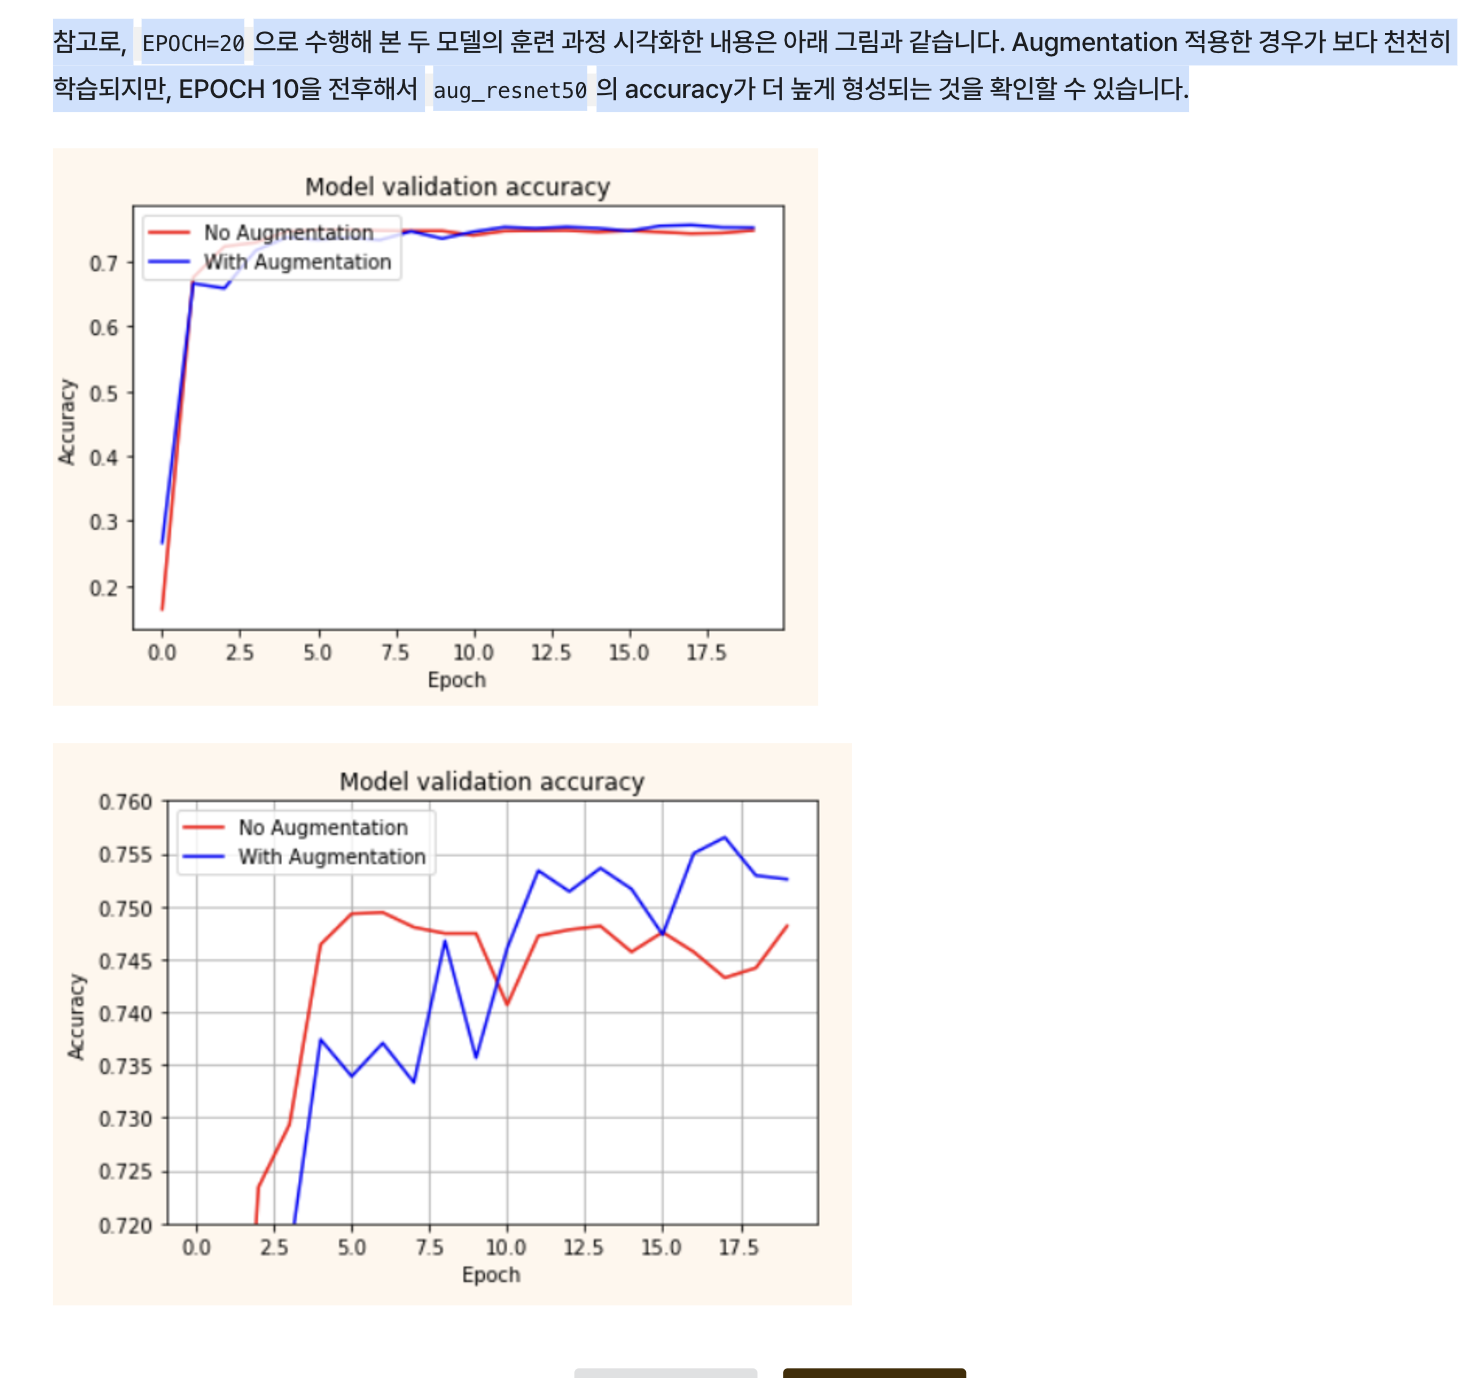

5-5. 심화 기법 (1) Cutmix Augmentation
지금부터 조금 더 복잡한 augmentation 방법을 알아보겠습니다.

첫 번째는 CutMix augmentation입니다.

CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features
Chris Deotte's CutMix and MixUp on GPU/TPU
CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법입니다. 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.

아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타냅니다. Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다. 차에 비유하면 블렌딩 같은 방법이죠.

두 번째 링크인 Chris Deotte's CutMix and MixUp on GPU/TPU에서는 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp을 확인 할 수 있습니다. 남은 스텝에서 CutMix와 MixUp을 구현하면서 참고하도록 합시다. 참고로 캐글에서 지금 참가하고 있는 대회와 비슷한 태스크의 경진대회가 있는 경우, 다른 사람들이 적용한 방법들을 찾아보는 것도 인사이트를 얻는 데 좋습니다.

CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함합니다. 이제 한 부분씩 구현해 보겠습니다.



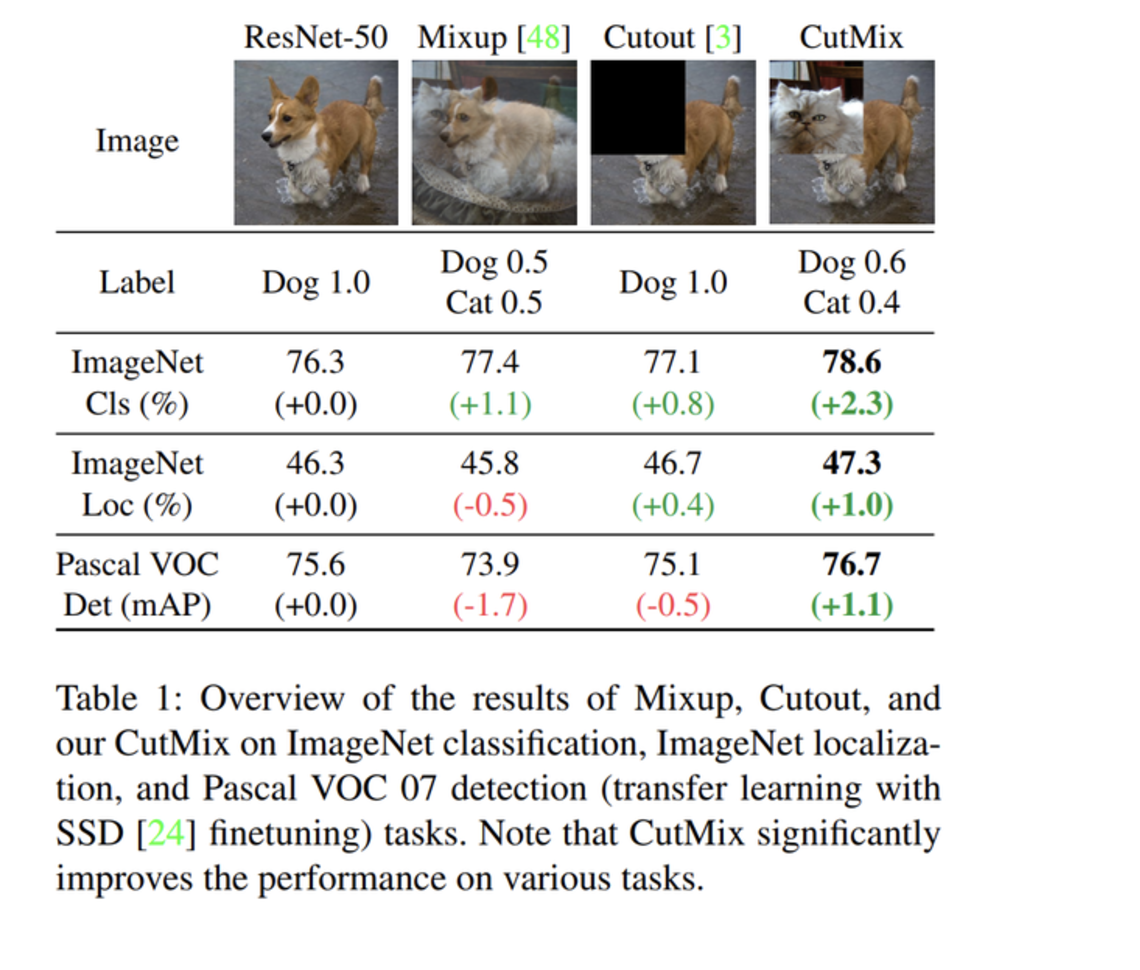

1) 이미지 섞기
가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

아래 코드 블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만들어 보세요! 이미지를 텐서로 만들어 텐서플로우 연산을 사용해 봅시다. 이때 이미지는 tfds에서 한 장을 뽑아서 사용해 보세요.






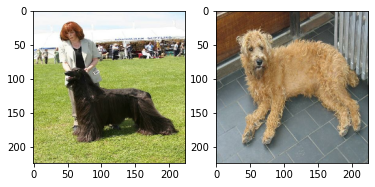

In [19]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두 개의 이미지를 얻었습니다.

이 중 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.

In [20]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    # 무작위로 중심점을 찾아 설정하는 것
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    # tf.random.uniform([], minval, maxval):
    # 0부터 image_size_x 또는 image_size_y 사이에서 무작위 값 생성.
    # tf.cast(..., tf.int32):
    # 결과를 정수형으로 변환.
    
    
    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    # 1 - tf.random.uniform([], 0, 1)을 통해 무작위로 박스 크기를 결정.
	# tf.math.sqrt는 박스 크기를 줄이는 역할을 합니다.
	# 예: 무작위 값이 0.5라면, \sqrt{0.5} \approx 0.71이므로 크기가 줄어듭니다.
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(105, shape=(), dtype=int32) tf.Tensor(187, shape=(), dtype=int32)
y :  tf.Tensor(143, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.
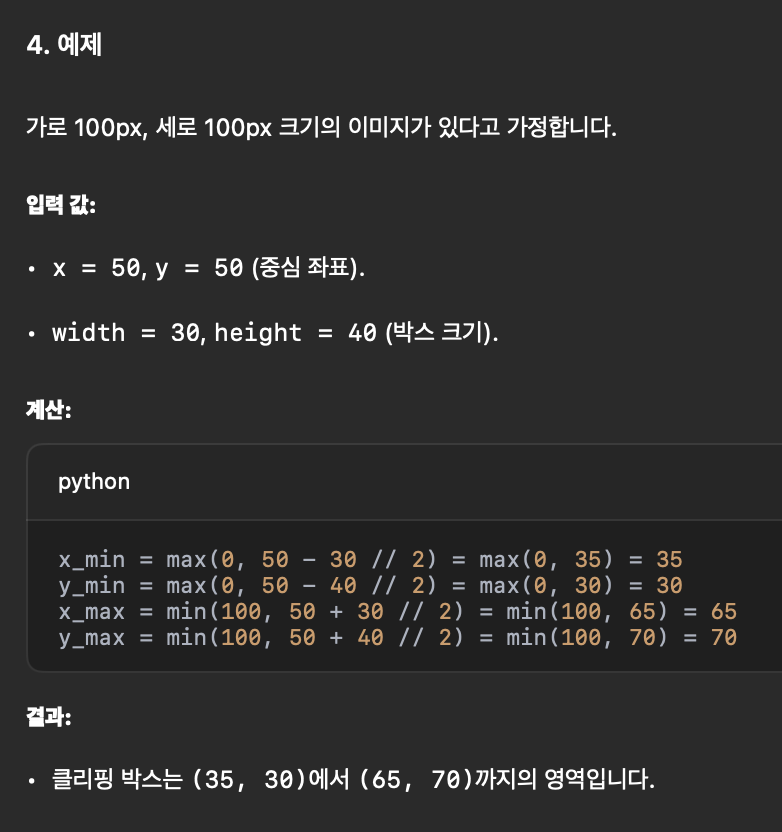





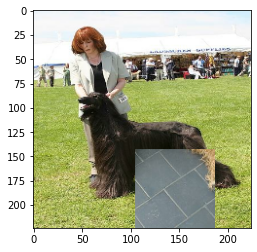

In [22]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역 = image a
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역 덮어쓸 중심영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역 = image a
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    # 세 부분을 하나의 middle 영역으로 결합합니다. 
    # axis=1: 가로 방향(너비)을 기준으로 결합.
    top = image_a[0:y_min, :, :] # 위쪽 영역!, x는 전부 : : image a
    bottom = image_a[y_max:image_size_y, :, :] # 아래쪽 영역!, x는 전부 : : image a
    mixed_img = tf.concat([top, middle, bottom],axis=0) # 모든 영역 세로(높이)로 결합
    
    return mixed_img # 최종 결합된 이미지 반환

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

2) 라벨 섞기  
이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.

CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅시다.






In [23]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.86762595,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13237405, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

이제 거의다 준비되었습니다.
위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 봅시다.






In [24]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b) # return x_min, y_min, x_max, y_max
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


5-6. 심화 기법 (2) Mixup Augmentation
Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다. 아래 참고자료는 앞에서 본 CutMix 비교표에서 "Mixup"이라는 방법이 제안된 논문입니다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있습니다. 아래에서 직접 Mixup 함수를 구현해보세요!

mixup:Beyond Empirical Risk Minimization
두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

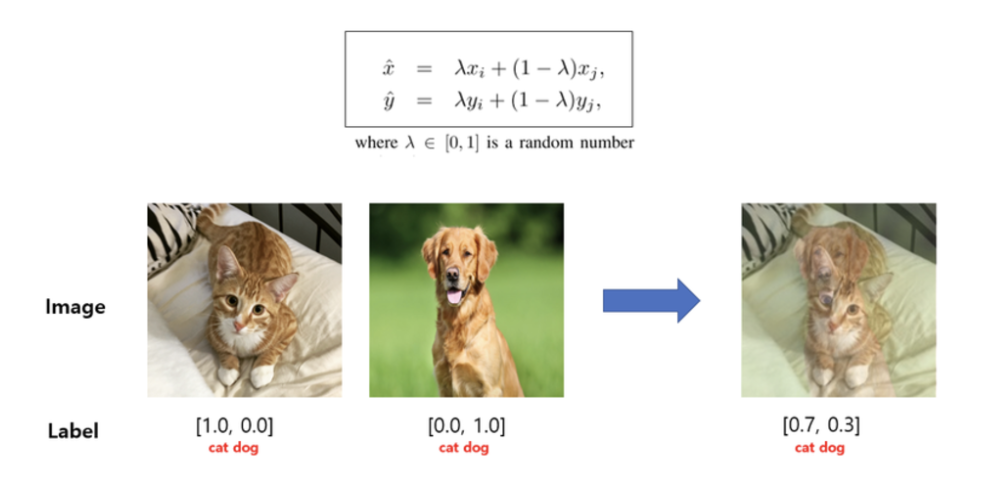

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
# 그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')